<img src="pyxel.png" width="100">
<center>_https://github.com/jcpassieux/pyxel_</center>

__Goal of the session__
1. Understand an implementation of the DIC (or Image Registration) problem
2. Implement a Tikhonov regularization based on the laplace operator
3. Implement an elastic regularization based on mechanical equilibrium
4. Perform an experimental displacement driven simulation
5. Validation of the above mechanical model wrt to experimental field
6. Identify a constitutive parameter from fullfield measurement

Let us consider an openhole glass/epoxy specimen subjected to a tensile test. The experiment
is instrumented with a CCD camera..

A set of images is taken before and during the mechanical test. The corresponding images are
given in folder `data/dic_composite/`.


# Step by step tutorial
## Start by importing some useful libraries

In [1]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse.linalg as splalg
import scipy as sp
import pyxel as px
import os

## Naming and loading images
Here a list of 11 images named like _zoom-0053.tif_. 
<br> The first one being the reference state image.

In [2]:
imnums=np.array([53,54,57,58,61,62,65,66,69,70,75])
imagefile=os.path.join('data','dic_composite','zoom-0%03d_1.tif')

**Load** and **plot** reference image

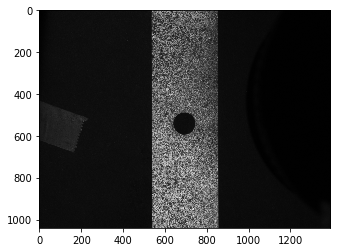

In [3]:
imref = imagefile % imnums[0]
f=px.Image(imref).Load()
f.Show()

Load the penultimate image

In [4]:
imdef = imagefile % imnums[-2]
g = px.Image(imdef).Load()

## Mesh and associated camera model
An example with a quadrilateral ABAQUS mesh using meter (m) unit.

In [5]:
meshfile=os.path.join('data','dic_composite','abaqus_q4_m.inp')
m=px.ReadMeshINP(meshfile)
l0=0.005     # regularization length

**Calibration** or **loading** the camera model parameters

In [6]:
#%matplotlib qt
#cam=px.MeshCalibration(f,m,[1,2])
#print(cam.get_p())
#%matplotlib inline
# or
cam=px.Camera(np.array([ 1.05168768e+04,  5.13737634e-02, -9.65935782e-02, -2.65443047e-03]))

Different ways to **plot the mesh**: (1) the mesh or (2) its projection on the image using matplotlib or (3) the generation of a _*.vtu_ file for Paraview.  

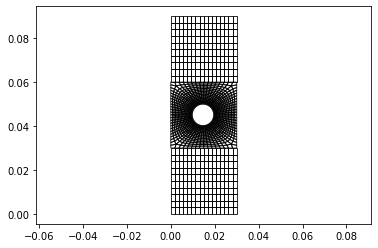

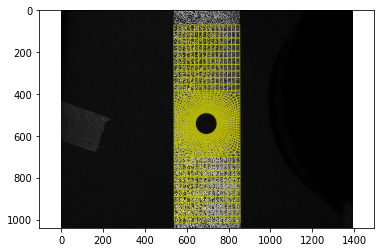

In [7]:
# Visualization of the mesh alone using Matplotlib
m.Plot()
# Plot Mesh on the reference image
px.PlotMeshImage(f,m,cam)

## Preprocessing
Build the **connectivity** table<br>
Build the **quadrature** rule + Compute **FE basis functions** and derivatives

In [8]:
m.Connectivity()
m.DICIntegration(cam)

Optionnal **multiscale initialization** of the displacement field

In [9]:
U0=px.MultiscaleInit(m,f,g,cam,3)

SCALE  3
Iter #  1 | disc/dyn=10.44 % | dU/U=1.00e+00
Iter #  2 | disc/dyn=7.54 % | dU/U=4.86e-01
Iter #  3 | disc/dyn=5.02 % | dU/U=2.41e-01
Iter #  4 | disc/dyn=3.80 % | dU/U=9.59e-02
Iter #  5 | disc/dyn=3.51 % | dU/U=3.52e-02
Iter #  6 | disc/dyn=3.45 % | dU/U=1.29e-02
Iter #  7 | disc/dyn=3.44 % | dU/U=4.88e-03
Iter #  8 | disc/dyn=3.44 % | dU/U=1.96e-03
Iter #  9 | disc/dyn=3.43 % | dU/U=8.36e-04
Iter # 10 | disc/dyn=3.43 % | dU/U=3.80e-04
Iter # 11 | disc/dyn=3.43 % | dU/U=1.84e-04
Iter # 12 | disc/dyn=3.43 % | dU/U=9.48e-05
Iter # 13 | disc/dyn=3.43 % | dU/U=5.10e-05
Iter # 14 | disc/dyn=3.43 % | dU/U=2.83e-05
Iter # 15 | disc/dyn=3.43 % | dU/U=1.60e-05
Iter # 16 | disc/dyn=3.43 % | dU/U=9.12e-06
SCALE  2
Iter #  1 | disc/dyn=4.89 % | dU/U=6.09e-02
Iter #  2 | disc/dyn=4.11 % | dU/U=1.53e-02
Iter #  3 | disc/dyn=4.07 % | dU/U=5.11e-03
Iter #  4 | disc/dyn=4.06 % | dU/U=1.90e-03
Iter #  5 | disc/dyn=4.06 % | dU/U=7.52e-04
Iter #  6 | disc/dyn=4.06 % | dU/U=3.10e-04
Iter #  7 | d

Plot the coarse initialization

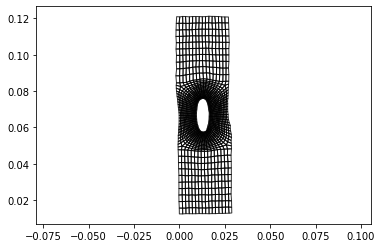

In [10]:
m.Plot(U0,30)

## DIC Solver without regularization
Initialization of U and DIC engine.<br>
**Assembly** and **factorization** of DIC operator **H**.

In [11]:
U=U0.copy()
dic=px.DICEngine()
H=dic.ComputeLHS(f,m,cam)
H_LU=splalg.splu(H)

**Gauss-Newton** iterations (without regularization)

In [12]:
for ik in range(0,30):
    [b,res]=dic.ComputeRHS(g,m,cam,U)
    d=H_LU.solve(b)
    U+=d
    err=np.linalg.norm(d)/np.linalg.norm(U)
    print("Iter # %2d | disc/dyn=%2.2f %% | dU/U=%1.2e" % (ik+1,np.std(res)/dic.dyn*100,err))
    if err<1e-3:
        break

Iter #  1 | disc/dyn=1.22 % | dU/U=1.49e-02
Iter #  2 | disc/dyn=0.96 % | dU/U=1.45e-03
Iter #  3 | disc/dyn=0.96 % | dU/U=2.07e-04


## Postprocessing
Visualization using matplotlib: **Scaled deformation of the mesh**

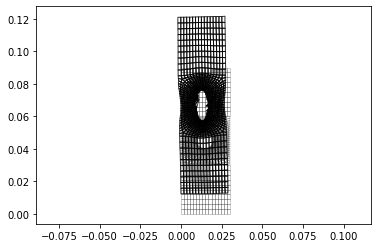

In [13]:
m.Plot(alpha=0.2)
m.Plot(U,30)
plt.show()

Visualization using matplotlib: **displacement fields**

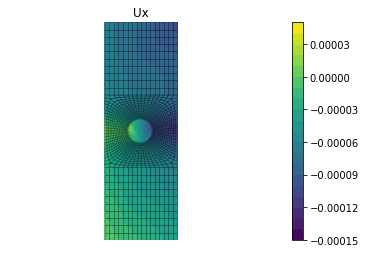

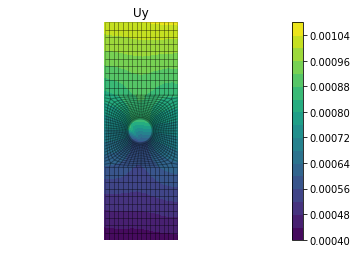

In [14]:
m.PlotContourDispl(U)

Visualization using matplotlib: **strain fields**

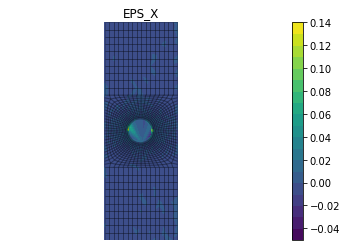

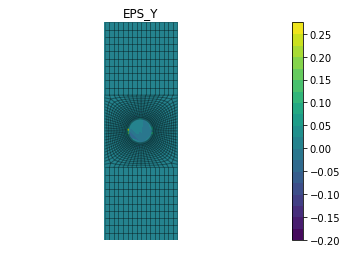

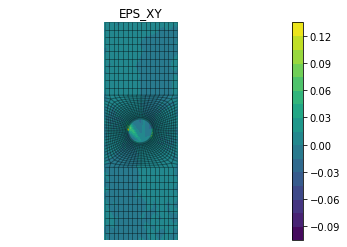

In [15]:
m.PlotContourStrain(U)

Plot deformed **Mesh** on deformed state **image**

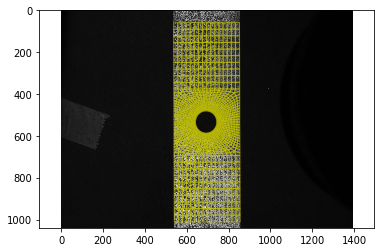

In [16]:
px.PlotMeshImage(g,m,cam,U)

# Exercices
## Time resolved DIC analysis 
Perform the measurement for all the time steps and plot the corresponding displacement field.<br>


In [22]:
U=np.zeros(m.ndof)
#TODO

## DIC with Tikhonov regularization
Reminder: a regularization term is added to the DIC functionnal $j(\mathbf d)$. <br> 
The regularized problem becomes:<br>
<center>
$\displaystyle \widetilde j(\mathbf d)=j(\mathbf d) + \frac \alpha 2 \; \mathbf u^T \; \mathbf A\; \mathbf u \quad $ </center>
with $\mathbf u=\mathbf u_0+\mathbf q$, the running approximation $\mathbf u_0$ being fixed. The parameter $\alpha$ can be interpreted as a filter cut-off. Many techniques exists to define a "good" value. For the sake of simplicity, try to find a value by trial and error.<br>
The stationnarity of the regularized functionnal with respect to displacement correction $\mathbf q$ reads:
<center>
$\mathbf H\; \mathbf d = \mathbf b \qquad \Rightarrow \qquad (\mathbf H + \alpha\; \mathbf A)\; \mathbf d = \mathbf b - \alpha\; \mathbf A \; \mathbf u_0 $
</center>

In [23]:
imdef = imagefile % imnums[-2]
g = px.Image(imdef).Load()
U=U0.copy()
A=m.Tikhonov()
#TODO

## DIC with Elastic Regularization
Same technique as before, but with a different regularization operator $\mathbf A$:<br>

<center>
$\mathbf A = \mathbf K^T \mathbf D\; \mathbf K  \qquad with \qquad \mathbf D =\begin{bmatrix}
    \mathbf I_{ni} & 0 \\
    0 & \mathbf 0_{nb}  
    \end{bmatrix}$
</center>
$\mathbf D$ is a diagonal matrix with null diagonal term for non-free boundary nodes and a one instead.

Define **Stiffness/Hooke tensor** (ortotropic in this case)

In [27]:
El=1.0e+10
Et=1.9e+10
vtl=0.18
Glt=1.0e+09
vlt=vtl*El/Et
alp=1/(1-vlt*vtl)
hooke=np.array([[alp*El     , alp*vtl*El,0    ],
                [alp*vlt*Et , alp*Et    ,0    ],
                [0          , 0         ,2*Glt]])

Assemble **stiffness matrix**

In [28]:
K=m.Stiffness(hooke)

Select or load the non-free boundary nodes (here two lines)

In [29]:
# repb1=px.SelectMeshLine(m)
# repb2=px.SelectMeshLine(m)
# or
repb1=np.array([ 12,  13, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235])
repb2=np.array([ 14,  15, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268])
repb=np.append(repb1,repb2)
dofb=m.conn[repb,:].ravel()
D=np.ones_like(U)
D[dofb]=0
D=sp.sparse.diags(D)
A=K.T.dot(D.dot(K))

FE-DIC with elastic regularization

In [ ]:
#TODO

### Experimental displacement driven simulation
Here, the goal is to perform a FE simulation on the same domain (same mesh) with measured boundary conditions.<br>
Find displacement $\mathbf v$ such that:

<center>
$\mathbf K\;\mathbf v = \mathbf 0 \qquad with \qquad \mathbf v|_{\partial_u\Omega} = \mathbf u|_{\partial_u\Omega}$
    </center>

In [ ]:
#TODO

### Model Validation 
Plot the distance map between simulated and measured displacements fields. When using the same FE basis for both simulation and measurement, it simply consists in comparing displacement dof-by-dof:

$\mathbf {dis} = abs(\mathbf u - \mathbf v)$

In [31]:
#TODO

### Constitutive parameter identification
For the sake of simplicity, let's try to identify only the Poisson's ratio $\nu_{tl}$ using a very basic FEMU approach. The functionnal reads:

<center>
$\mathcal J^{femu} = \frac 1 2 \| \mathbf u-\mathbf v(\mathbf p)\|^2$
</center>

$\mathbf u$ being the experimental displacement and $\mathbf v$ the simulated displacement fields that depends on the vector of constitutive parameters $\mathbf p$

To linearize the problem, the parameter $\mathbf p$ is sought in the form of $\mathbf p = \mathbf p_{0} + \mathbf q$, the running approximation $\mathbf p_0$ begin fixed. The stationnarity of the above functionnal with respect to constitutive parameter update $\mathbf q$ reads:

<center>
$\displaystyle \frac{\partial \mathbf v}{\partial \mathbf p}^T  \frac{\partial \mathbf v}{\partial \mathbf p} \; \mathbf q = - \frac{\partial \mathbf v}{\partial \mathbf p}^T (\mathbf u-\mathbf v(\mathbf p_0))$
</center>

The sensitivities $\frac{\partial \mathbf v}{\partial \mathbf p}$ (derivative of the displacement with respect to the parameter) is computed numerically by finite differences.

In [30]:
#TODO (may require more time than is available...)